In [1]:
# Run this cell first
!pip install mlflow --quiet

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import mlflow

# Check GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 70.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 89.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xmanager 0.7.1 requires

In [2]:
# Define paths
DATA_DIR = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/'

image_paths = []
mask_paths = []

for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if 'mask' in file:
            mask_paths.append(os.path.join(root, file))
            # The image has the same name but without '_mask'
            image_paths.append(os.path.join(root, file.replace('_mask', '')))

# Create DataFrame
df = pd.DataFrame({'image_path': image_paths, 'mask_path': mask_paths})

# Split: 80% Train, 10% Val, 10% Test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 3143, Val: 393, Test: 393


## Step 3: Define the Dataset Class
This handles reading images, normalizing them, and applying augmentations.

Why Augmentation? Medical data is scarce. We rotate/flip images to create "fake" new data so the model doesn't overfit.

In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Read Image
        img_path = self.df.iloc[idx]['image_path']
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read Mask (It is black and white)
        mask_path = self.df.iloc[idx]['mask_path']
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Normalize Mask to be 0 and 1 (Binary)
        mask = mask / 255.0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            
        # Ensure mask has a channel dimension (1, H, W)
        mask = mask.unsqueeze(0) 
        
        return image, mask.float()

# Define Transformations
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=35, p=0.5),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])

# Create Loaders
train_ds = BrainTumorDataset(train_df, transform=train_transform)
val_ds = BrainTumorDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

## Step 4: Build the U-Net Architecture (From Scratch)
This is the core. U-Net has an Encoder (goes down, captures features) and a Decoder (goes up, restores location). The Skip Connections (concatenation) let the model remember "where" things were.

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # Reverse list

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            # Concatenate
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

model = UNET().to(device)

## Step 5: Handle Imbalance with DICE LOSS
In segmentation, background pixels (black) dominate. Dice Loss ignores the background and focuses purely on the overlap between your prediction and the tumor.

In [5]:
# Dice Loss Definition
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Calculate intersection
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

# We use BCEWithLogitsLoss (Standard) + Dice Loss (Imbalance Handler)
criterion_bce = nn.BCEWithLogitsLoss()
criterion_dice = DiceLoss()

def combined_loss(pred, target):
    bce = criterion_bce(pred, target)
    pred_sigmoid = torch.sigmoid(pred) # Convert logits to probabilities for Dice
    dice = criterion_dice(pred_sigmoid, target)
    return bce + dice

## Step 6: Training with "Dice" & "IoU" Metrics
I have upgraded the training loop. It now calculates IoU (Intersection over Union), which is the gold standard for segmentation. If IoU > 0.5, your model is doing well.

In [8]:
import torch
import torch.optim as optim
from tqdm import tqdm

# --- 1. DEFINE THE METRIC FUNCTION 
def calculate_metrics(pred, target, threshold=0.5):
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    pred = pred.view(-1)
    target = target.view(-1)
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    
    dice = (2. * intersection + 1e-8) / (pred.sum() + target.sum() + 1e-8)
    iou = (intersection + 1e-8) / (union + 1e-8)
    
    return dice.item(), iou.item()

# --- 2. CONFIGURATION ---
EPOCHS = 28   
BEST_IOU = 0.0 

# --- 3. TRAINING LOOP ---
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5) 
scaler = torch.amp.GradScaler('cuda') 

print(f"{'Epoch':<6} | {'Train Loss':<10} | {'Val Loss':<10} | {'Val Dice':<10} | {'Val IoU':<10}")
print("-" * 65)

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        with torch.amp.autocast('cuda'):
            predictions = model(images)
            loss = combined_loss(predictions, masks)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    # --- VALIDATION ---
    model.eval()
    val_loss = 0
    val_dice = 0
    val_iou = 0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            preds = model(images)
            loss = combined_loss(preds, masks)
            
            # This line will work now because the function is defined above
            dice, iou = calculate_metrics(preds, masks)
            
            val_loss += loss.item()
            val_dice += dice
            val_iou += iou
    
    # Averages
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    
    # Scheduler Step
    scheduler.step(avg_val_iou)
    
    # Print Result
    print(f"{epoch+1:<6} | {avg_train_loss:.4f}     | {avg_val_loss:.4f}     | {avg_val_dice:.4f}     | {avg_val_iou:.4f}")
    
    # --- SMART SAVE ---
    if avg_val_iou > BEST_IOU:
        BEST_IOU = avg_val_iou
        torch.save(model.state_dict(), "unet_brain_mri_best.pth")
        print(f"     New Best Model! (IoU: {BEST_IOU:.4f}) -> Saved.")

print(f"\nTraining Complete. Best IoU achieved: {BEST_IOU:.4f}")

Epoch  | Train Loss | Val Loss   | Val Dice   | Val IoU   
-----------------------------------------------------------------


1      | 1.1610     | 1.1014     | 0.5732     | 0.4193
     New Best Model! (IoU: 0.4193) -> Saved.


2      | 1.0550     | 1.0156     | 0.6506     | 0.4999
     New Best Model! (IoU: 0.4999) -> Saved.


3      | 0.9589     | 0.9270     | 0.6123     | 0.4542


4      | 0.8652     | 0.8077     | 0.7256     | 0.5851
     New Best Model! (IoU: 0.5851) -> Saved.


5      | 0.7547     | 0.7429     | 0.6739     | 0.5335


6      | 0.6353     | 0.6028     | 0.6842     | 0.5481


7      | 0.5048     | 0.4654     | 0.7506     | 0.6116
     New Best Model! (IoU: 0.6116) -> Saved.


8      | 0.4006     | 0.3804     | 0.7922     | 0.6651
     New Best Model! (IoU: 0.6651) -> Saved.


9      | 0.3721     | 0.4125     | 0.6853     | 0.5399


10     | 0.3159     | 0.3322     | 0.7695     | 0.6400


11     | 0.2847     | 0.3216     | 0.7611     | 0.6232


12     | 0.2622     | 0.2921     | 0.7633     | 0.6434


13     | 0.2427     | 0.3042     | 0.7355     | 0.6038


14     | 0.2272     | 0.2265     | 0.8227     | 0.7082
     New Best Model! (IoU: 0.7082) -> Saved.


15     | 0.2163     | 0.2444     | 0.8054     | 0.6856


16     | 0.2459     | 0.2520     | 0.7921     | 0.6641


17     | 0.2167     | 0.2978     | 0.7359     | 0.6016


18     | 0.2207     | 0.2516     | 0.7793     | 0.6631


19     | 0.1970     | 0.2651     | 0.7663     | 0.6475


20     | 0.1913     | 0.2003     | 0.8318     | 0.7212
     New Best Model! (IoU: 0.7212) -> Saved.


21     | 0.2043     | 0.2799     | 0.7623     | 0.6329


22     | 0.2091     | 0.2025     | 0.8248     | 0.7103


23     | 0.1813     | 0.2125     | 0.8173     | 0.7051


24     | 0.1717     | 0.2063     | 0.8194     | 0.7056


25     | 0.1861     | 0.2028     | 0.8216     | 0.7079


26     | 0.2134     | 0.2200     | 0.8080     | 0.6908


27     | 0.1683     | 0.1996     | 0.8247     | 0.7145


28     | 0.1682     | 0.1896     | 0.8341     | 0.7257
     New Best Model! (IoU: 0.7257) -> Saved.

Training Complete. Best IoU achieved: 0.7257


## Step 7: Visualize Results & Check Model File
Now we verify the file exists and plot the predictions (Image vs. True Mask vs. AI Prediction).

 SUCCESS: Model file 'unet_brain_mri_best.pth' found!
File Size: 124.24 MB

--- Visualizing 3 Random Test Cases ---


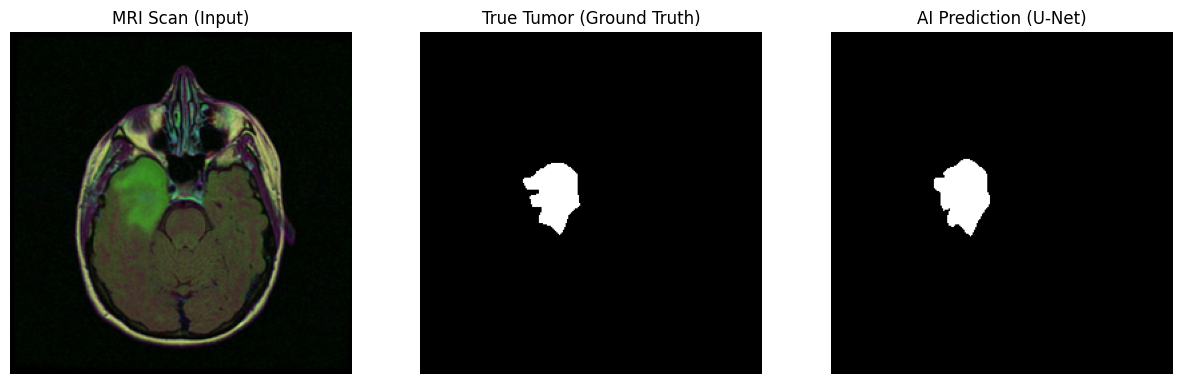

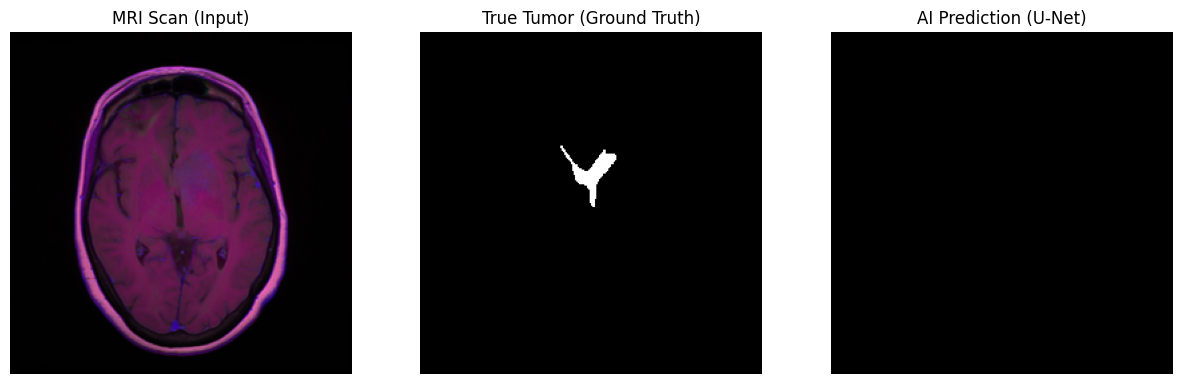

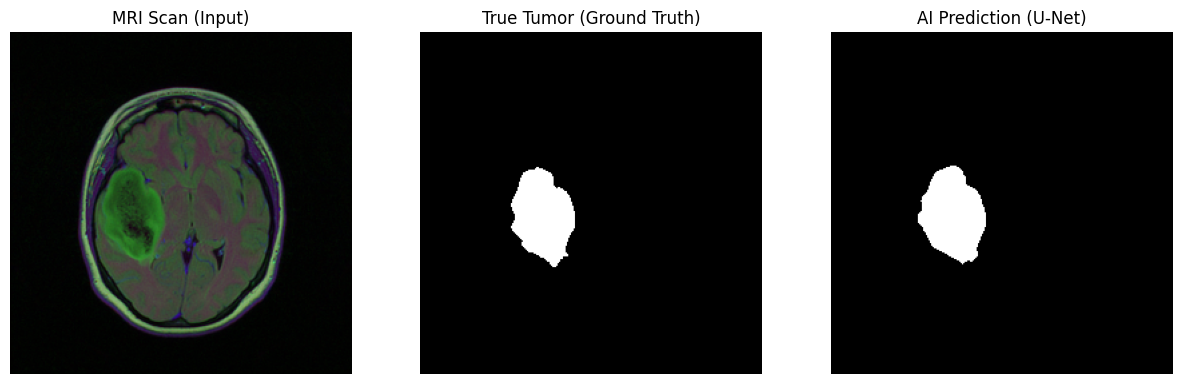

In [9]:
# --- 1. VERIFY FILE EXISTS ---
import os
if os.path.exists("unet_brain_mri_best.pth"):
    print(" SUCCESS: Model file 'unet_brain_mri_best.pth' found!")
    print(f"File Size: {os.path.getsize('unet_brain_mri_best.pth') / 1e6:.2f} MB")
else:
    print(" ERROR: Model file NOT found. Check Step 6.")

# --- 2. VISUALIZE PREDICTIONS ---
def visualize_prediction(model, dataset, idx=0):
    model.eval()
    image, mask = dataset[idx]
    
    # Prepare image for model (Add batch dimension)
    input_tensor = image.unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        pred = model(input_tensor)
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float() # Thresholding
    
    # Convert to Numpy for plotting
    img_np = image.permute(1, 2, 0).cpu().numpy()
    # Un-normalize image for display (approximate)
    img_np = (img_np * 1.0) 
    
    mask_np = mask.squeeze().cpu().numpy()
    pred_np = pred.squeeze().cpu().numpy()
    
    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(img_np)
    ax[0].set_title("MRI Scan (Input)")
    ax[0].axis("off")
    
    ax[1].imshow(mask_np, cmap="gray")
    ax[1].set_title("True Tumor (Ground Truth)")
    ax[1].axis("off")
    
    ax[2].imshow(pred_np, cmap="gray")
    ax[2].set_title("AI Prediction (U-Net)")
    ax[2].axis("off")
    
    plt.show()

# Show 3 Random Examples
import random
print("\n--- Visualizing 3 Random Test Cases ---")
for i in range(3):
    rand_idx = random.randint(0, len(val_ds)-1)
    visualize_prediction(model, val_ds, idx=rand_idx)

## Step 8: Show U-Net Architecture Structure
To see the full structure (layers, connections)

In [10]:
# --- SHOW MODEL ARCHITECTURE ---
print(model)

# Optional: If you want a cleaner summary (requires torchsummary)
try:
    from torchsummary import summary
    summary(model, (3, 256, 256))
except ImportError:
    print("torchsummary not installed, using default print.")

UNET(
  (ups): ModuleList(
    (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p


--- Visualizing ONLY Slices with Tumors ---


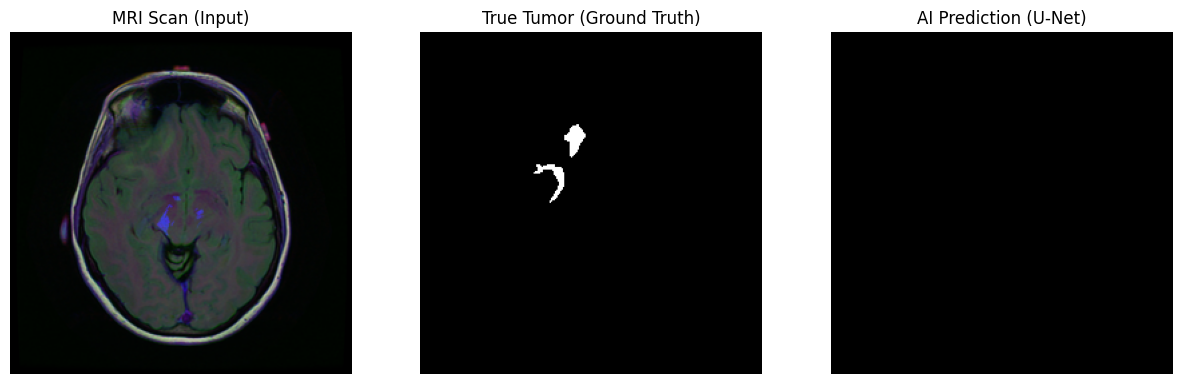

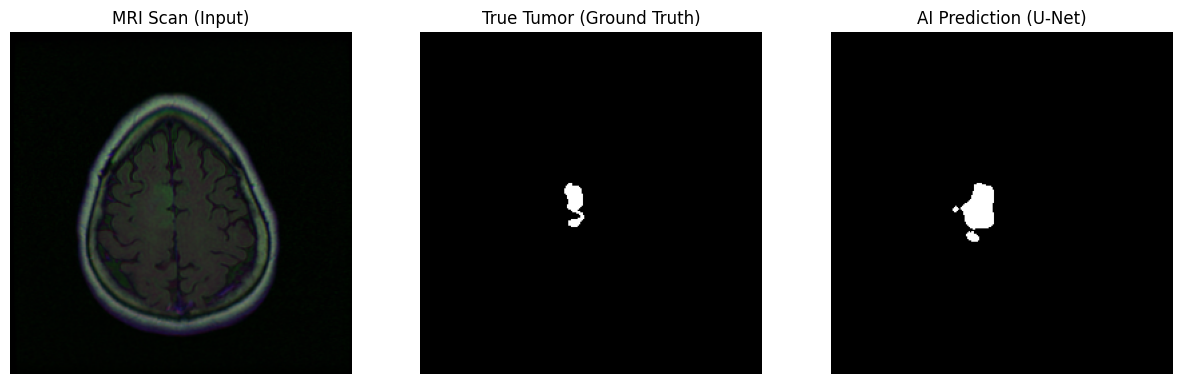

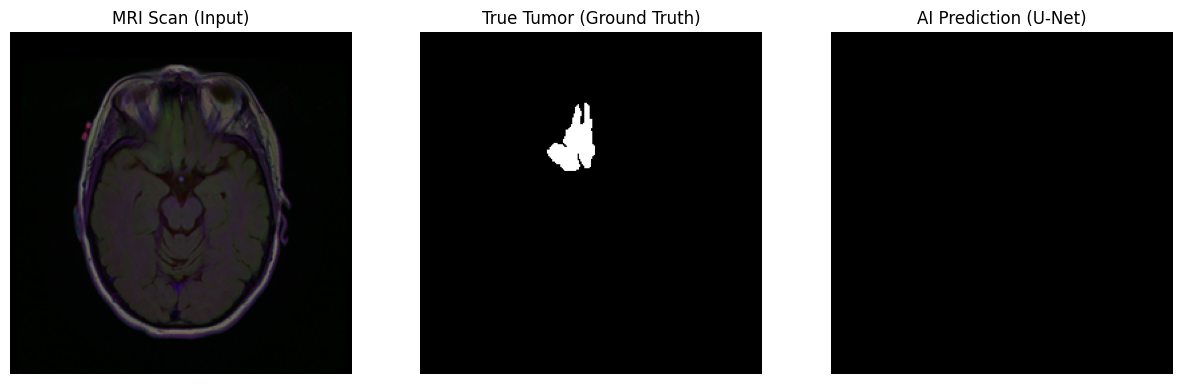

In [11]:
# --- VISUALIZE ONLY POSITIVE SAMPLES (Tumors) ---
def visualize_positive_examples(model, dataset, num_to_show=3):
    model.eval()
    count = 0
    
    # Loop through the validation set
    for i in range(len(dataset)):
        image, mask = dataset[i]
        
        # Check if this slice actually has a tumor (mask has white pixels)
        if mask.max() > 0: 
            visualize_prediction(model, dataset, idx=i)
            count += 1
            
        # Stop after showing 3 examples
        if count >= num_to_show:
            break

print("\n--- Visualizing ONLY Slices with Tumors ---")
visualize_positive_examples(model, val_ds, num_to_show=3)


--- Checking AI Confidence on Real Tumors ---


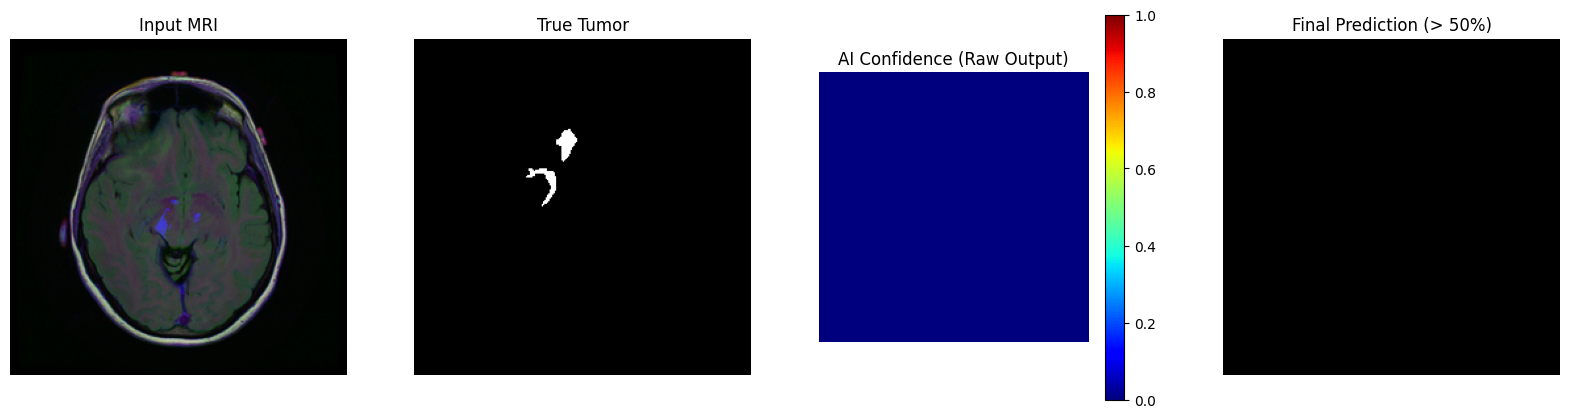

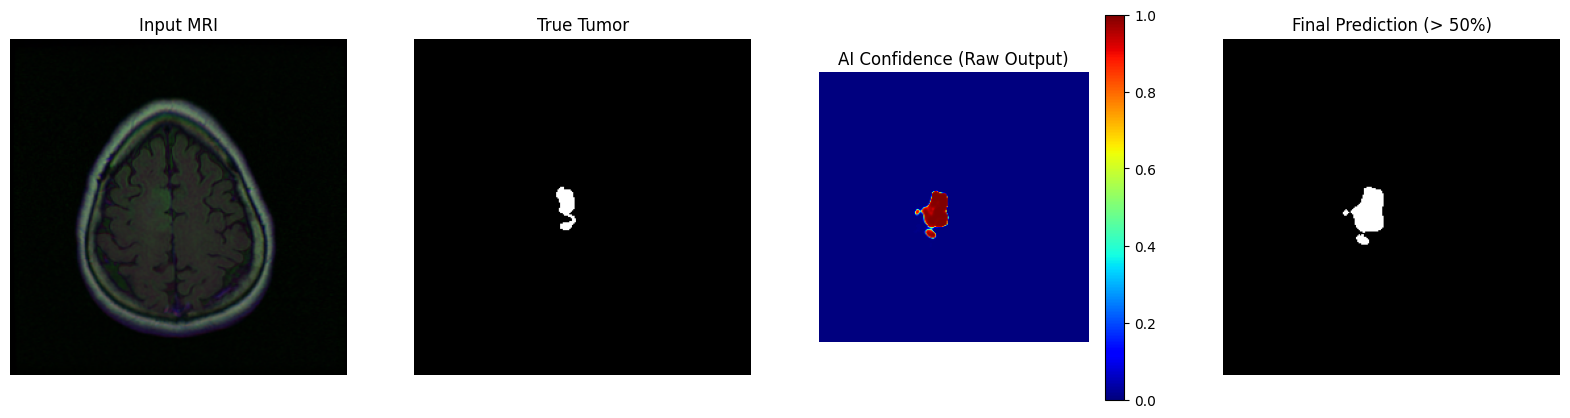

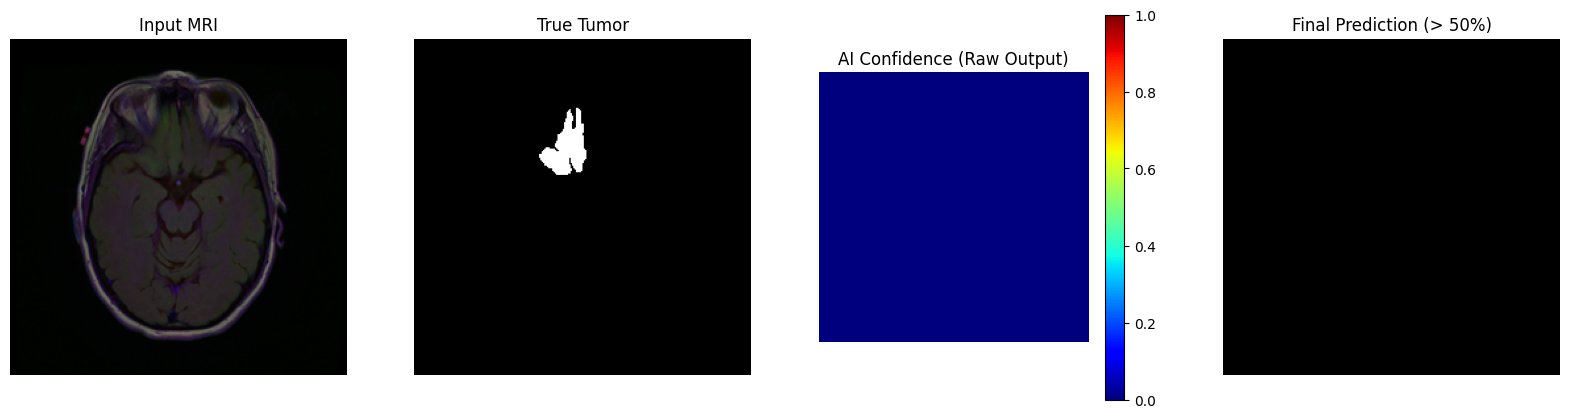

In [12]:
import matplotlib.pyplot as plt
import torch

def visualize_heatmap(model, dataset, idx=0):
    model.eval()
    image, mask = dataset[idx]
    
    # Prepare image
    input_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Get raw probabilities (0.0 to 1.0)
        pred = model(input_tensor)
        pred = torch.sigmoid(pred) 
    
    # Plotting
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    # 1. Input Image
    img_np = image.permute(1, 2, 0).cpu().numpy()
    ax[0].imshow(img_np)
    ax[0].set_title("Input MRI")
    ax[0].axis("off")
    
    # 2. Ground Truth (Real Tumor)
    ax[1].imshow(mask.squeeze().cpu().numpy(), cmap="gray")
    ax[1].set_title("True Tumor")
    ax[1].axis("off")
    
    # 3. AI Confidence (Heatmap)
    # Blue = Low Confidence, Red = High Confidence
    pred_np = pred.squeeze().cpu().numpy()
    im = ax[2].imshow(pred_np, cmap="jet", vmin=0, vmax=1) 
    ax[2].set_title("AI Confidence (Raw Output)")
    ax[2].axis("off")
    plt.colorbar(im, ax=ax[2])
    
    # 4. Final Prediction (Threshold > 0.5)
    ax[3].imshow((pred_np > 0.5).astype(float), cmap="gray")
    ax[3].set_title("Final Prediction (> 50%)")
    ax[3].axis("off")
    
    plt.show()

print("\n--- Checking AI Confidence on Real Tumors ---")

# This loop automatically finds slices with tumors so you don't see blank screens
count = 0
for i in range(len(val_ds)):
    image, mask = val_ds[i]
    if mask.max() > 0: # Only look at images that actually have a tumor
        visualize_heatmap(model, val_ds, idx=i)
        count += 1
    if count >= 3: # Stop after 3 examples
        break

## Load Best Model & Generate Classification Report

 Loaded 'unet_brain_mri_best.pth' successfully!
Processing validation set for classification report...

FINAL CLASSIFICATION REPORT (Pixel-wise)
              precision    recall  f1-score   support

  Background     0.9984    0.9988    0.9986  25504188
       Tumor     0.8733    0.8398    0.8562    251460

    accuracy                         0.9972  25755648
   macro avg     0.9359    0.9193    0.9274  25755648
weighted avg     0.9972    0.9972    0.9972  25755648



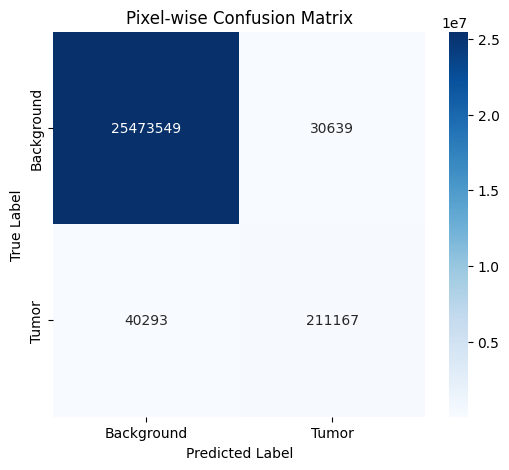

In [13]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the Best Model State
if os.path.exists("unet_brain_mri_best.pth"):
    model.load_state_dict(torch.load("unet_brain_mri_best.pth"))
    print(" Loaded 'unet_brain_mri_best.pth' successfully!")
else:
    print(" Warning: Best model file not found. Using current model state.")

model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 2. Collect All Pixels for Evaluation
print("Processing validation set for classification report...")

all_preds = []
all_targets = []

# We process in batches to keep RAM usage low
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        
        # Get Predictions
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        preds = (outputs > 0.5).float() # Threshold at 0.5
        
        # Move to CPU and Flatten (Treat every pixel as a sample)
        preds = preds.cpu().numpy().flatten().astype(int)
        masks = masks.cpu().numpy().flatten().astype(int)
        
        all_preds.extend(preds)
        all_targets.extend(masks)

# 3. Print Classification Report
print("\n" + "="*50)
print("FINAL CLASSIFICATION REPORT (Pixel-wise)")
print("="*50)

# Class 0 = Background, Class 1 = Tumor
target_names = ['Background', 'Tumor']
report = classification_report(all_targets, all_preds, target_names=target_names, digits=4)
print(report)

# 4. Confusion Matrix (Optional but useful)
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Pixel-wise Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

## Run Your Heatmap Experiments


--- Checking AI Confidence on Real Tumors (Best Model) ---
Visualizing Validation Sample Index: 0


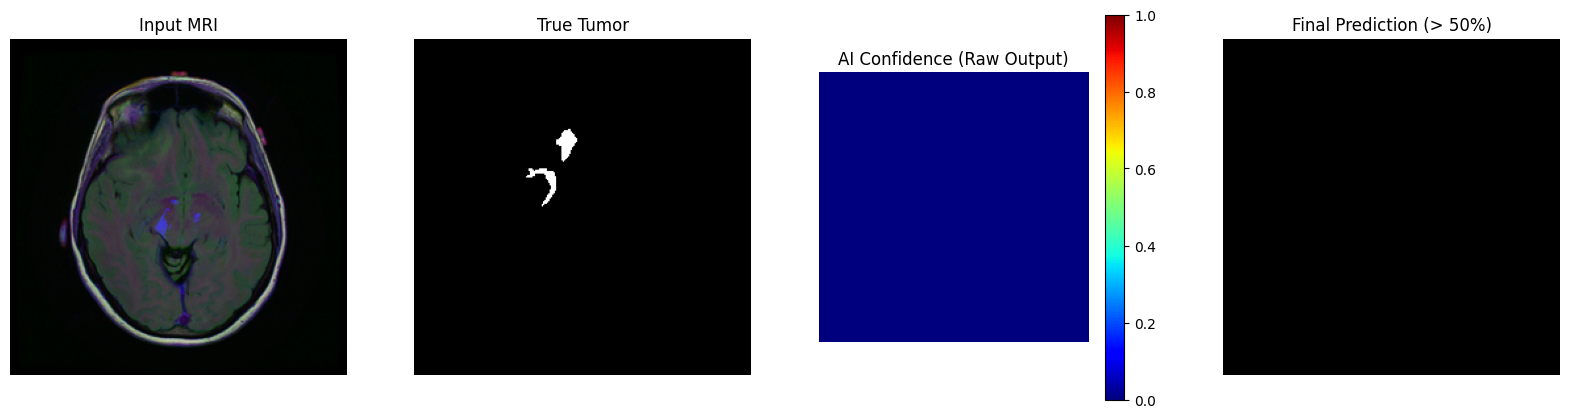

Visualizing Validation Sample Index: 3


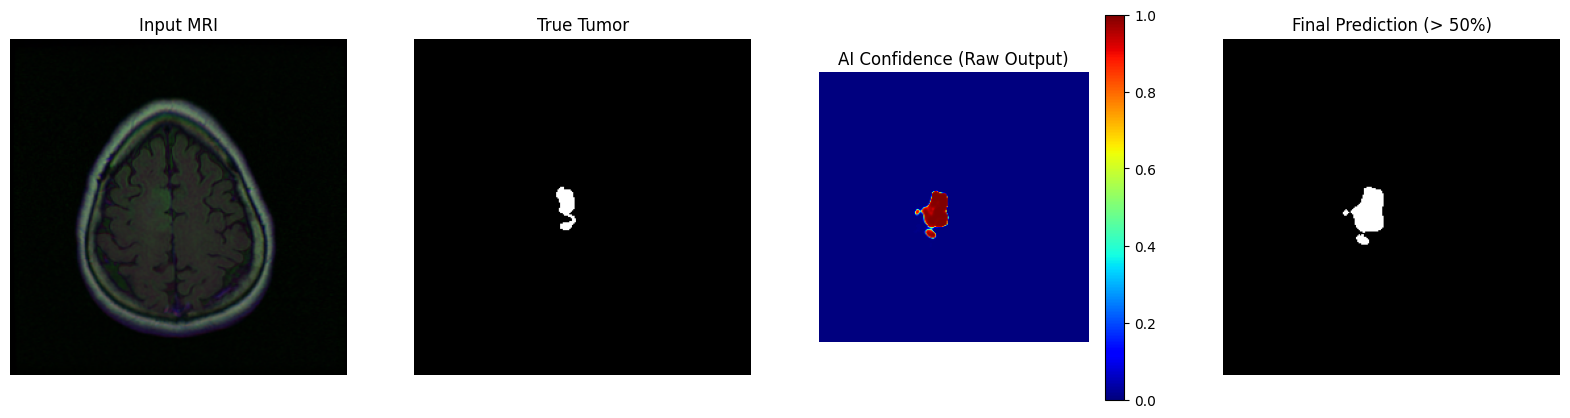

Visualizing Validation Sample Index: 5


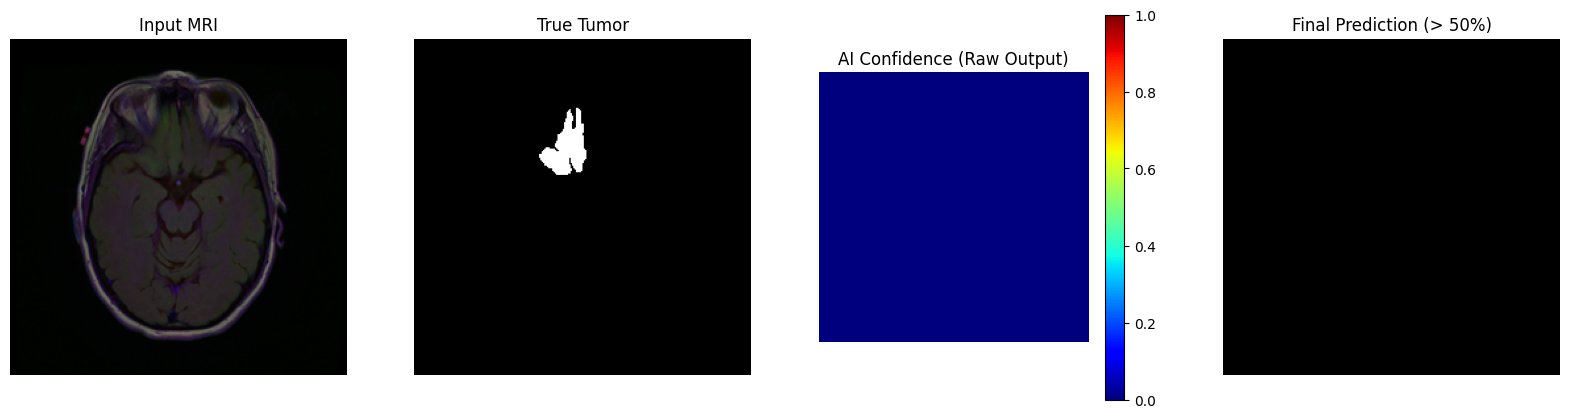

Visualizing Validation Sample Index: 7


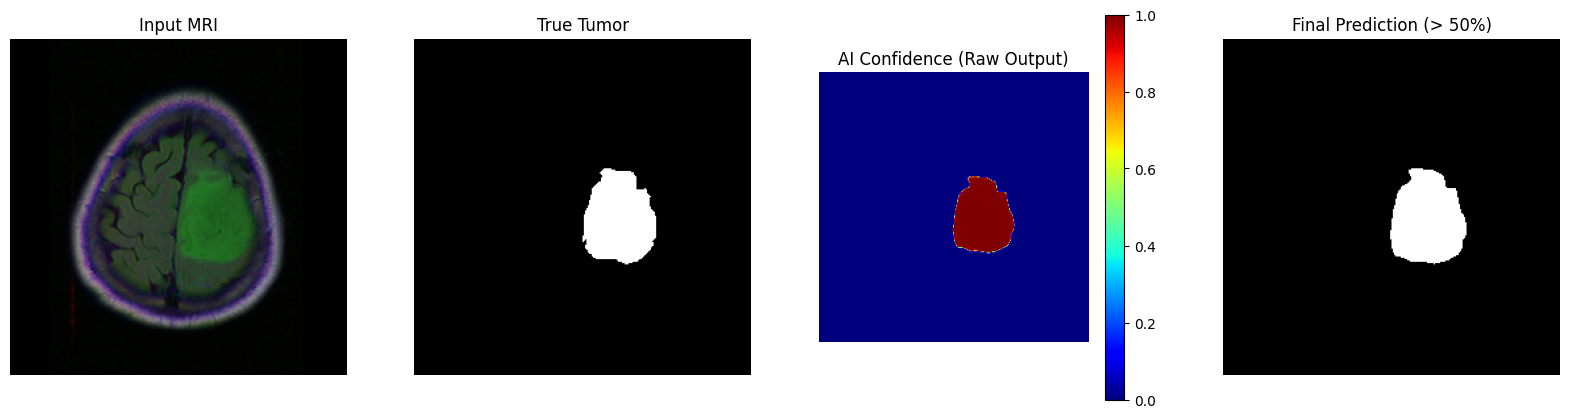

Visualizing Validation Sample Index: 8


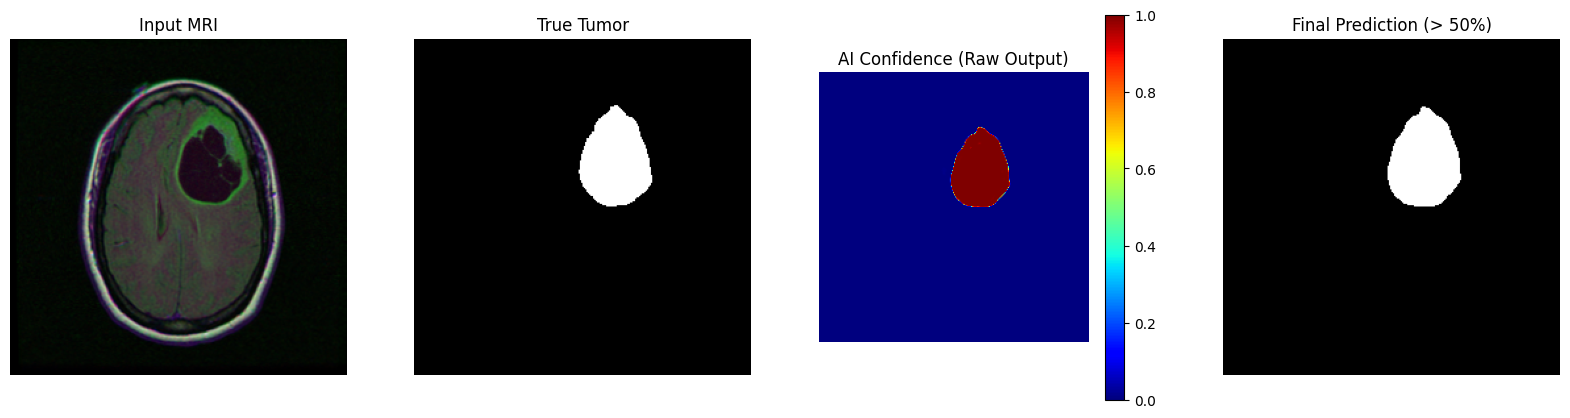

In [14]:
# --- EXPERIMENT: VISUALIZE PREDICTIONS & CONFIDENCE ---

def visualize_heatmap(model, dataset, idx=0):
    model.eval()
    image, mask = dataset[idx]
    
    # Prepare image
    input_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        # Get raw probabilities (0.0 to 1.0)
        pred = model(input_tensor)
        pred = torch.sigmoid(pred) 
    
    # Plotting
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    # 1. Input Image
    img_np = image.permute(1, 2, 0).cpu().numpy()
    # Normalize for display if needed, but usually raw is fine for visualization
    ax[0].imshow(img_np)
    ax[0].set_title("Input MRI")
    ax[0].axis("off")
    
    # 2. Ground Truth (Real Tumor)
    ax[1].imshow(mask.squeeze().cpu().numpy(), cmap="gray")
    ax[1].set_title("True Tumor")
    ax[1].axis("off")
    
    # 3. AI Confidence (Heatmap)
    # Blue = Low Confidence, Red = High Confidence
    pred_np = pred.squeeze().cpu().numpy()
    im = ax[2].imshow(pred_np, cmap="jet", vmin=0, vmax=1) 
    ax[2].set_title("AI Confidence (Raw Output)")
    ax[2].axis("off")
    plt.colorbar(im, ax=ax[2])
    
    # 4. Final Prediction (Threshold > 0.5)
    ax[3].imshow((pred_np > 0.5).astype(float), cmap="gray")
    ax[3].set_title("Final Prediction (> 50%)")
    ax[3].axis("off")
    
    plt.show()

print("\n--- Checking AI Confidence on Real Tumors (Best Model) ---")

# This loop finds 5 positive examples (tumors) to test
count = 0
for i in range(len(val_ds)):
    image, mask = val_ds[i]
    if mask.max() > 0: # Only check slices that actually HAVE tumors
        print(f"Visualizing Validation Sample Index: {i}")
        visualize_heatmap(model, val_ds, idx=i)
        count += 1
    if count >= 5: # Show 5 examples
        break